In [1]:
pip install scikit-learn==0.22.1

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [10]:
import sklearn as skl
print(skl.__version__)
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import ensemble 
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

0.22.1


<img src="data/cheat-sheet.png">

In [17]:
df = pd.read_csv("data/kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


data check

In [10]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

data Data Visualization

In [18]:
df = df[df.columns[2:14]]

<Figure size 432x288 with 0 Axes>

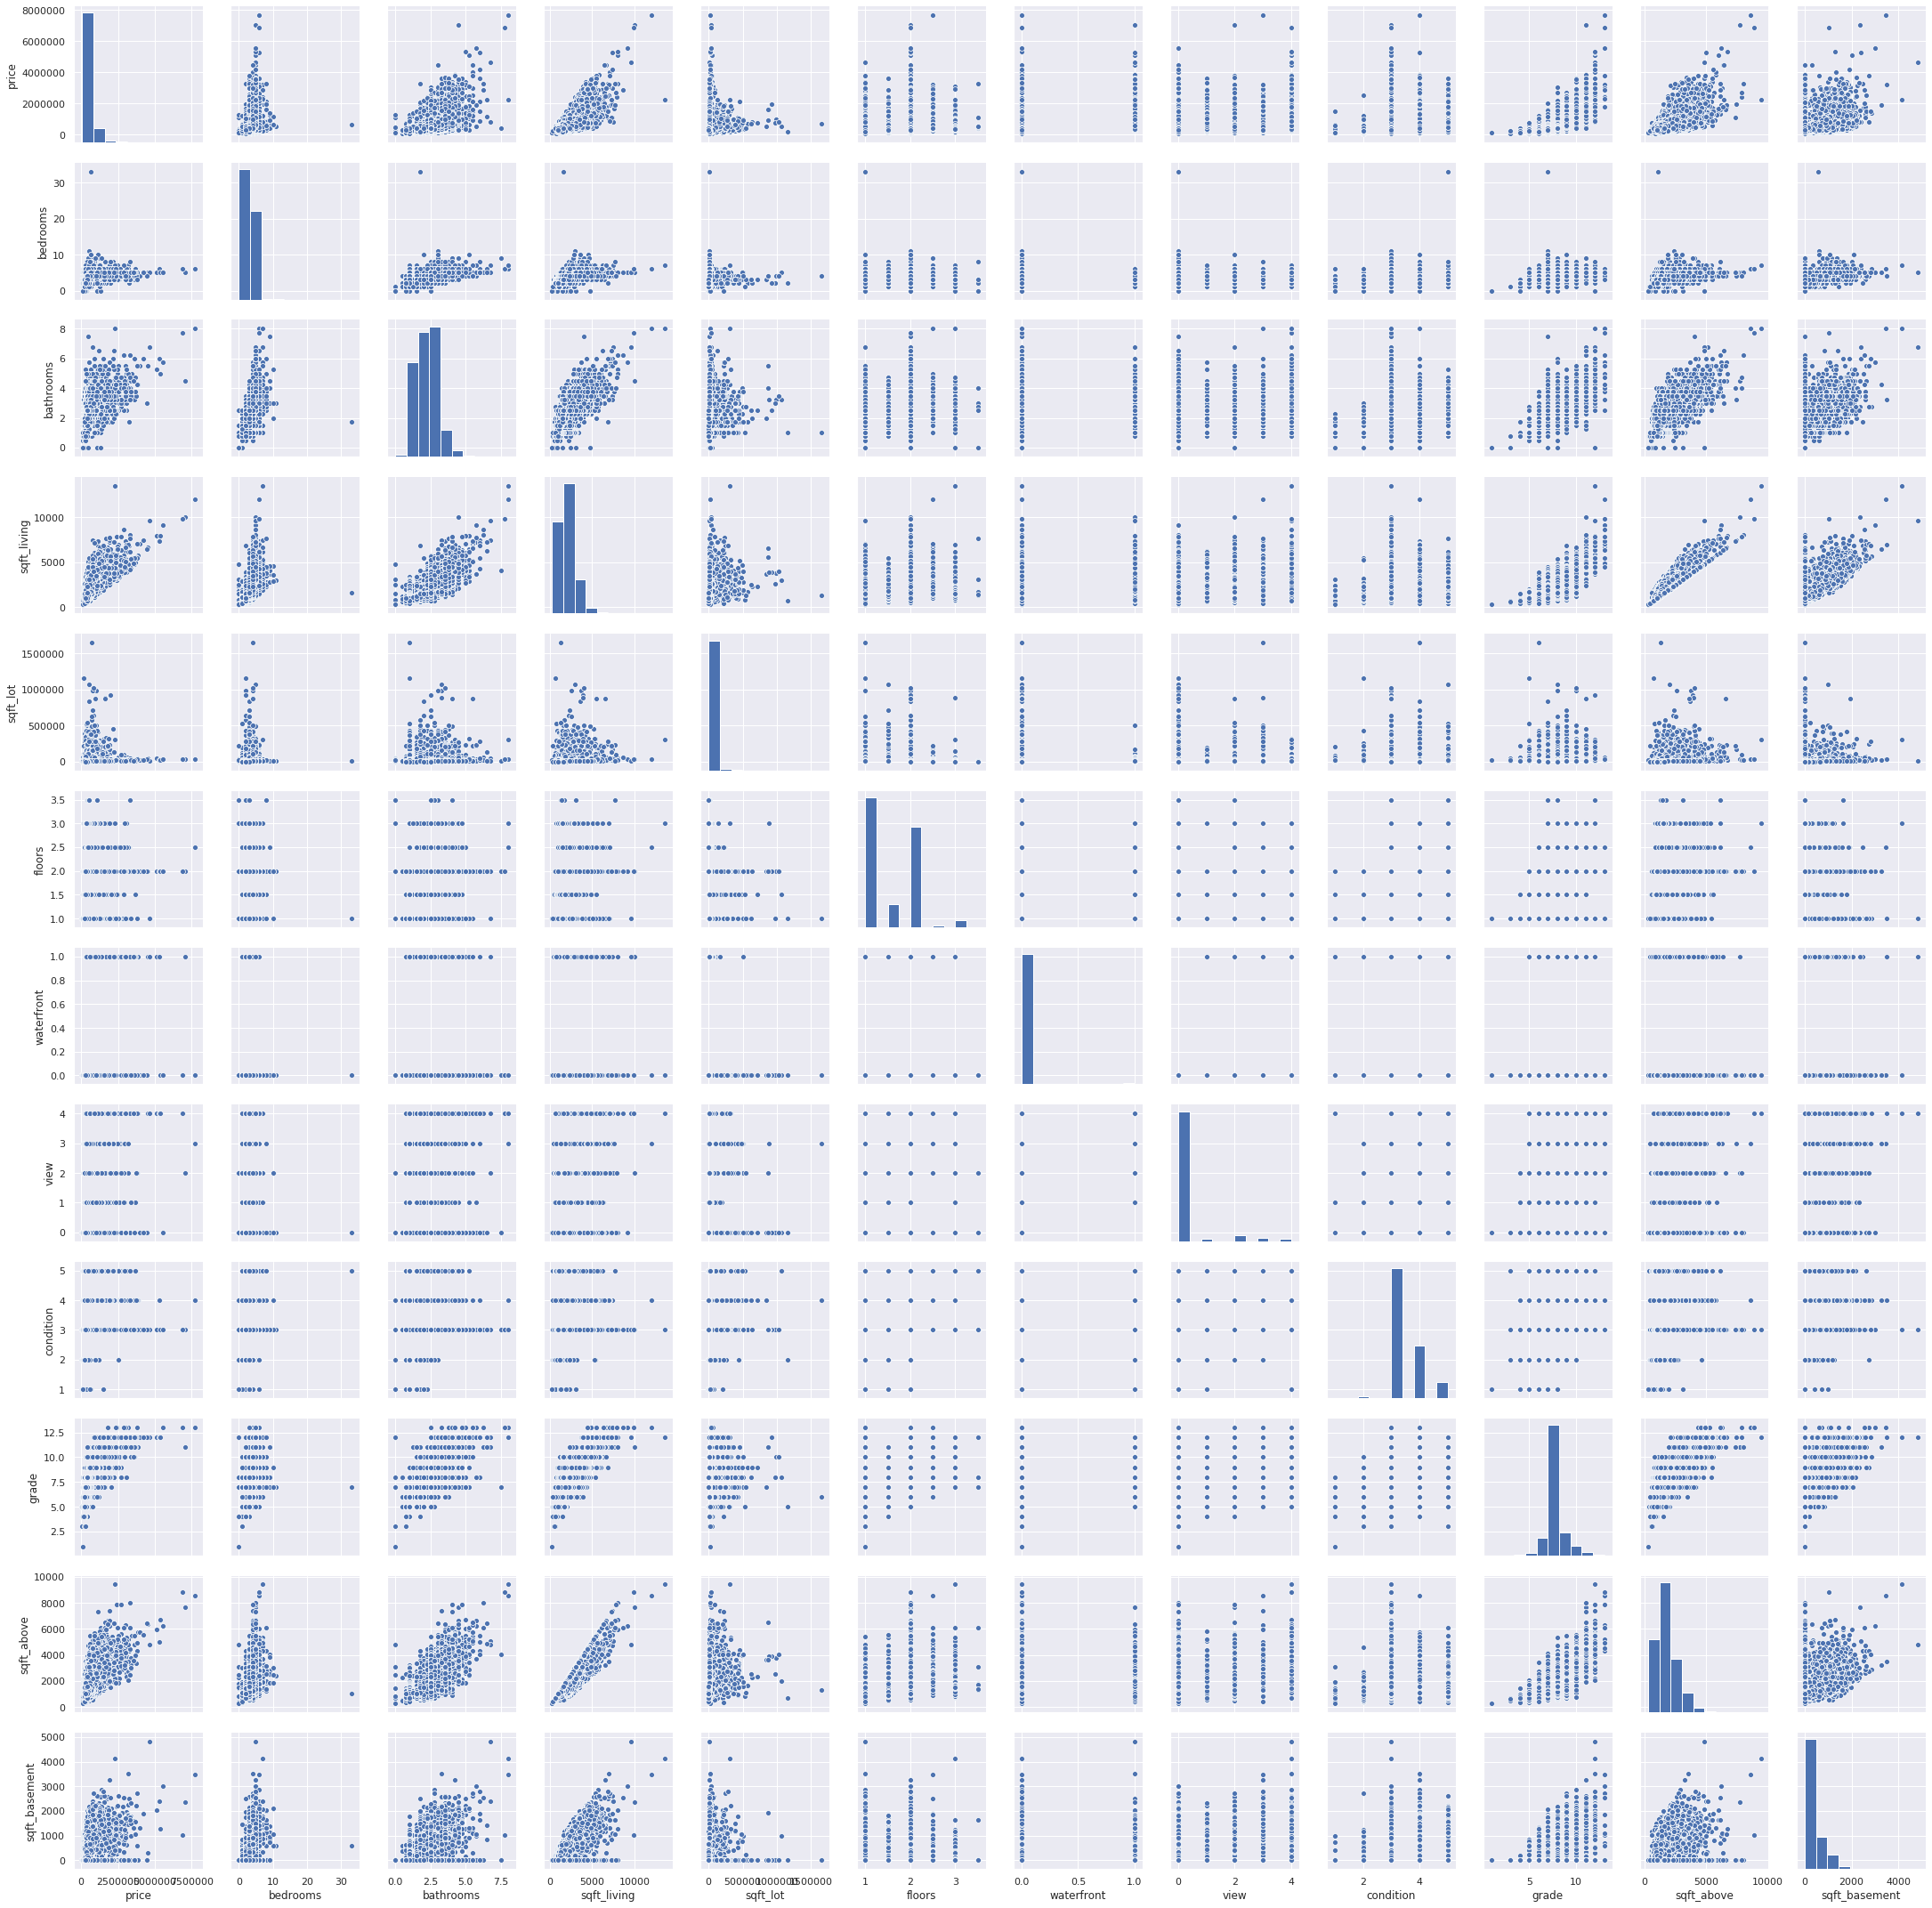

In [55]:
plt.figure()
sns.pairplot(df)

In [6]:
correlation = df.corr(method='pearson')
columns = correlation.nlargest(10, 'price').index
# waterfront view 和 basement 分布及其不均匀，因此舍弃
# above和live存在多重共线性，根据AIC值舍弃sqft_living
columns = ['price', 'sqft_living', 'grade','bathrooms', 'bedrooms','floors']

Index(['price', 'sqft_living', 'grade', 'sqft_above', 'bathrooms', 'view',
       'sqft_basement', 'bedrooms', 'waterfront', 'floors'],
      dtype='object')

In [19]:
columns = ['price', 'sqft_living', 'grade','bathrooms', 'bedrooms','floors']

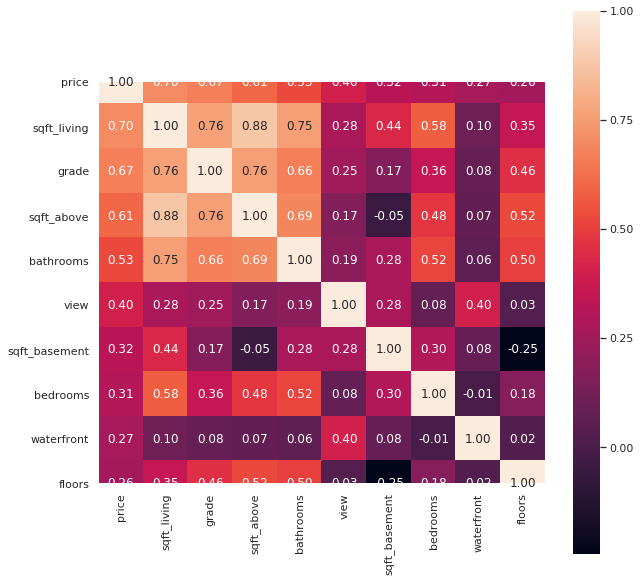

In [7]:
correlation_map = np.corrcoef(df[columns].values.T)
sns.set(font_scale=1.0)
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)


In [8]:
# scaling
for item in columns:
    df[item] = preprocessing.scale(df[item])

In [20]:
df = df[columns]
df.shape

(21613, 6)

select feature

In [12]:
#定义向前逐步回归函数
# 摘自 https://blog.csdn.net/weixin_44835596/article/details/89763300 作者: 取经之路上
def forward_select(data,target):
    variate=set(data.columns)  #将字段名转换成字典类型
    variate.remove(target)  #去掉因变量的字段名
    selected=[]
    current_score,best_new_score=float('inf'),float('inf')  #目前的分数和最好分数初始值都为无穷大（因为AIC越小越好）
    #循环筛选变量
    while variate:
        aic_with_variate=[]
        for candidate in variate:  #逐个遍历自变量
            formula="{}~{}".format(target,"+".join(selected+[candidate]))  #将自变量名连接起来
            aic=ols(formula=formula,data=data).fit().aic  #利用ols训练模型得出aic值
            aic_with_variate.append((aic,candidate))  #将第每一次的aic值放进空列表
        aic_with_variate.sort(reverse=True)  #降序排序aic值
        best_new_score,best_candidate=aic_with_variate.pop()  #最好的aic值等于删除列表的最后一个值，以及最好的自变量等于列表最后一个自变量
        if current_score>best_new_score:  #如果目前的aic值大于最好的aic值
            variate.remove(best_candidate)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
            selected.append(best_candidate)  #将此自变量作为加进模型中的自变量
            current_score=best_new_score  #最新的分数等于最好的分数
            print("aic is {},continuing!".format(current_score))  #输出最小的aic值
        else:
            print("for selection over!")
            break
    formula="{}~{}".format(target,"+".join(selected))  #最终的模型式子
    print("final formula is {}".format(formula))
    model=ols(formula=formula,data=data).fit()
    return(selected)


In [26]:
column = forward_select(data=df,target="price")

aic is 46664.78680875252,continuing!
aic is 44814.69341032757,continuing!
aic is 44460.862769531304,continuing!
aic is 44312.02162593024,continuing!
aic is 44300.29757023945,continuing!
final formula is price~sqft_living+grade+bedrooms+floors+bathrooms


In [27]:
column

['sqft_living', 'grade', 'bedrooms', 'floors', 'bathrooms']

In [28]:
lm1 = ols("price~sqft_living+grade+bedrooms+floors+bathrooms", data=df).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     5188.
Date:                Sat, 08 Feb 2020   Prob (F-statistic):               0.00
Time:                        06:20:39   Log-Likelihood:                -22144.
No. Observations:               21613   AIC:                         4.430e+04
Df Residuals:                   21607   BIC:                         4.435e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.125e-17      0.005  -6.81e-15      1.000      -0.009       0.009
sqft_living     0.5539      0.009     61.422      0.000       0.536       0.572
grade           0.3267      0.008     42.873      0.000       0.312       0.342
bedrooms       -0.1030      0.006    -17.757      0.000      -0.114      -0.092
floors         -0.0565      0.005    -10.287      0.000      -0.067      -0.046
bathrooms      -0.0287      0.008     -3.705      0.000      -0.044      -0.014
==============================================================================
Omnibus:                    16389.166   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           882634.199
Skew:                           3.156   Prob(JB):                         0.00
Kurtosis:                      33.664   Cond. No.                         4.26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
x = df[['sqft_living', 'grade', 'bedrooms', 'floors', 'bathrooms']]
print(x.shape)
y = df['price']
print(y.shape)

(21613, 5)
(21613,)


In [22]:
# split train_test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
print(len(x_train))
print(len(y_train))

16209
16209


In [41]:
pca = PCA(n_components=5)
pca.fit(x_train)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.61862349 0.176413   0.11264098 0.05820984 0.03411269]
[223.30995108 119.25048844  95.28907087  68.50039208  52.43881359]


In [42]:
tx_test = pca.transform(x_test)
tx_train = pca.transform(x_train)

广义线性模型

In [43]:
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)
print(reg.coef_)
print(reg.intercept_)
print(reg.score(x_test, y_test))

[ 0.36136101  0.03679844 -0.42425532  0.13118035 -0.28954207]
-0.007130824443672103
0.551687079033033


In [44]:
# 建立模型
# 需满足古典假定，多因子还需满足无共线性假定
# 优点：如果满足古典假定则最小二乘法为最优无偏估计
# 缺点：过于理想化
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)
print(reg.coef_)
print(reg.intercept_)

[ 0.54601265  0.31771445 -0.10035059 -0.05898164 -0.01870891]
-0.002011002485586554


In [51]:
# 模型检验
y_pred = reg.predict(x_test)
print('mse: ', metrics.mean_squared_error(y_test, y_pred))
print('R2 score: ', metrics.r2_score(y_test, y_pred))
print('evs: ', metrics.explained_variance_score(y_test, y_pred))
print('cv score:', cross_val_score(reg, x, y, cv=5))

mse:  0.4975811274272414
R2 score:  0.5516870790330332
evs:  0.5517453620463286
cv score: [0.53456974 0.54071632 0.53241291 0.54815392 0.5614372 ]


Ridge regression

In [56]:
# 建立模型
# 在广义线性模型的基础上加入惩罚项，最小化带惩罚项的残差平方和实行最小化 惩罚系数越大，系数越收缩，对多重共线性的鲁棒性就越强
# 由于加入了限制条件，岭回归是有偏估计
# 优点：可以较好解决线性回归的共线性问题
# 缺点：剔除变量(变量一同收束)和选择合适的岭参数是难点，常数项基本不为零
reg = linear_model.Ridge()
reg.fit(x_train, y_train)
print(reg.coef_)
print(reg.intercept_)

[ 0.54591173  0.31772334 -0.10031789 -0.05897936 -0.01865634]
-0.0020114976455373494


In [55]:
# 选择超参数
parameters = {'alpha':np.arange(0.5, 1.5, 0.1)}
reg = linear_model.Ridge()
reg-gs = GridSearchCV(reg, parameters)
reg-gs.fit(x_train, y_train)
pd.DataFrame(reg-gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007868,0.002742,0.011781,0.011904,0.5,{'alpha': 0.5},0.521186,0.535682,0.573595,0.544976,0.534879,0.542064,0.017498,10
1,0.026704,0.014353,0.017107,0.014801,0.6,{'alpha': 0.6},0.521186,0.535682,0.573594,0.544977,0.534880,0.542064,0.017498,9
2,0.032519,0.018596,0.018127,0.012566,0.7,{'alpha': 0.7},0.521186,0.535681,0.573594,0.544977,0.534881,0.542064,0.017498,8
3,0.018133,0.016265,0.027110,0.015026,0.8,{'alpha': 0.7999999999999999},0.521186,0.535681,0.573593,0.544977,0.534882,0.542064,0.017498,7
4,0.010749,0.010861,0.010634,0.011747,0.9,{'alpha': 0.8999999999999999},0.521185,0.535680,0.573593,0.544978,0.534883,0.542064,0.017497,6
5,0.018171,0.017256,0.017041,0.012422,1,{'alpha': 0.9999999999999999},0.521185,0.535680,0.573593,0.544978,0.534885,0.542064,0.017497,5
6,0.042661,0.015735,0.018191,0.014144,1.1,{'alpha': 1.0999999999999999},0.521185,0.535679,0.573592,0.544978,0.534886,0.542064,0.017497,4
7,0.023878,0.012710,0.020218,0.013309,1.2,{'alpha': 1.1999999999999997},0.521184,0.535679,0.573592,0.544979,0.534887,0.542064,0.017497,3
8,0.018789,0.012803,0.027719,0.016134,1.3,{'alpha': 1.2999999999999998},0.521184,0.535679,0.573592,0.544979,0.534888,0.542064,0.017497,2
9,0.022397,0.016893,0.013099,0.016200,1.4,{'alpha': 1.4},0.521184,0.535678,0.573591,0.544980,0.534889,0.542064,0.017497,1


In [57]:
# 模型检验
y_pred = reg.predict(x_test)
print('mse: ', metrics.mean_squared_error(y_test, y_pred))
print('R2 score: ', metrics.r2_score(y_test, y_pred))
print('evs: ', metrics.explained_variance_score(y_test, y_pred))
print('cv score:', cross_val_score(reg, x, y, cv=5))

mse:  0.49758488640772264
R2 score:  0.5516836922495993
evs:  0.5517420039679484
cv score: [0.53456451 0.54071298 0.53241788 0.54815822 0.56144045]


Lasso

In [12]:
# 建立模型
# 一阶通过构造一个一阶惩罚函数获得精炼的模型，即惩罚项为|w|，残差需符合正态分布，无自相关
# 优点：相比ridge，lasso具有很好的选择变量的特性而且也可以很好的处理共线性问题
reg = linear_model.Lasso(alpha=0.1)
reg.fit(x_train, y_train)
print(reg.coef_)
print(reg.intercept_)

[ 0.40163993  0.2506678  -0.         -0.          0.        ]
-0.0034012901556583156


In [13]:
# 选择超参数
parameters = {'alpha':np.arange(0.5, 1.5, 0.1)}
reg = linear_model.Lasso()
reg-gs = GridSearchCV(reg, parameters)
reg-gs.fit(x_train, y_train)
pd.DataFrame(reg-gs.cv_results_)

SyntaxError: can't assign to operator (<ipython-input-13-2a4bf358f77c>, line 4)

In [14]:
# 模型检验
y_pred = reg.predict(x_test)
print('mse: ', metrics.mean_squared_error(y_test, y_pred))
print('R2 score: ', metrics.r2_score(y_test, y_pred))
print('evs: ', metrics.explained_variance_score(y_test, y_pred))
print('cv score:', cross_val_score(reg, x, y, cv=5))

mse:  0.5299114731673206
R2 score:  0.5225579361944592
evs:  0.5227246625075996
cv score: [0.50325533 0.51577462 0.52107594 0.53304223 0.53774973]


Polynomial 

In [18]:
# 通过将特征转化为多项式形式，实现曲面划分，解决直线不可分的问题
# 优点：能够解决线性不可分的情况
# 缺点：容易过拟合，需要选择的参数较多，不好调
model = Pipeline([('poly', preprocessing.PolynomialFeatures(degree=2)),
                  ('linear', linear_model.Ridge())])
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.5720025265446376

In [19]:
# 模型检验
y_pred = model.predict(x_test)
print('mse: ', metrics.mean_squared_error(y_test, y_pred))
print('R2 score: ', metrics.r2_score(y_test, y_pred))
print('evs: ', metrics.explained_variance_score(y_test, y_pred))
print('cv score:', cross_val_score(reg, x, y, cv=5))

mse:  0.47503307493031616
R2 score:  0.5720025265446376
evs:  0.5720124786583318
cv score: [0.50325533 0.51577462 0.52107594 0.53304223 0.53774973]


SVM-regression

In [41]:
# 基于支持向量，寻找到分界面最远点的最小距离的MMH，将所有类视为一类，探寻他们间的关系
# 优点：可解决高维问题，处理非线性
# 缺点：使用小数据量，不同的核函数有不同的参数，选择困难，计算速度慢
# linear： 优点：快速简单 缺点：只能用于线性可分的数据
# poly：优点：通过升维解决线性不可分的问题 缺点：degree太大会过拟合
# rbf：优点：可到无穷维度 缺点：可解释性差，速度慢
reg = svm.SVR()
reg.fit(x_train, y_train)
reg.score(x_test, y_test)

0.5749158521131472

In [44]:
# 选择超参数
para = {'kernel':('rbf', 'linear', 'poly')}
reg = svm.SVR()
reg2 = GridSearchCV(reg, para)
reg2.fit(x_train, y_train)
pd.DataFrame(reg2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.559850,0.146454,1.351812,0.015327,rbf,{'kernel': 'rbf'},0.498244,0.512407,0.598894,0.582431,0.580853,0.554566,0.040944,1
1,20.394164,0.349726,0.374345,0.007369,linear,{'kernel': 'linear'},0.470632,0.489580,0.524665,0.509392,0.514960,0.501846,0.019362,2
2,72.695607,6.496927,0.539463,0.007401,poly,{'kernel': 'poly'},0.335549,0.351604,0.465658,0.486509,0.405908,0.409045,0.059861,3


In [43]:
# 模型检验
y_pred = model.predict(x_test)
print('mse: ', metrics.mean_squared_error(y_test, y_pred))
print('R2 score: ', metrics.r2_score(y_test, y_pred))
print('evs: ', metrics.explained_variance_score(y_test, y_pred))
print('cv score:', cross_val_score(reg, x, y, cv=5))

mse:  0.47503307493031616
R2 score:  0.5720025265446376
evs:  0.5720124786583318
cv score: [0.54968822 0.53198141 0.54641941 0.57725818 0.59747274]


决策树回归

In [39]:
# 通过递归对特征空间进行划分，划分依据一般是mse
# 优点：可处理高维数据，可筛选重要变量，易解释结果，快速
# 缺点：会受到噪声影响
reg = tree.DecisionTreeRegressor(criterion='friedman_mse')
reg.fit(x_train, y_train)
reg.score(x_test, y_test)

0.29166867095862636

In [38]:
# 选择超参数
para = {'criterion':('mse', 'friedman_mse', 'mae')}
reg = tree.DecisionTreeRegressor()
reg2 = GridSearchCV(reg, para)
reg2.fit(x_train, y_train)
pd.DataFrame(reg2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.039968,0.000145,0.003682,0.000027,mse,{'criterion': 'mse'},0.364633,0.358808,0.321270,0.305233,0.301524,0.330293,0.026568,1
1,0.039076,0.000177,0.003644,0.000032,friedman_mse,{'criterion': 'friedman_mse'},0.354552,0.339520,0.327341,0.307201,0.304852,0.326693,0.018963,2
2,4.416393,0.024418,0.003763,0.000076,mae,{'criterion': 'mae'},0.320582,0.312822,0.377788,0.321843,0.249936,0.316594,0.040610,3


In [40]:
# 模型检验
y_pred = model.predict(x_test)
print('mse: ', metrics.mean_squared_error(y_test, y_pred))
print('R2 score: ', metrics.r2_score(y_test, y_pred))
print('evs: ', metrics.explained_variance_score(y_test, y_pred))
print('cv score:', cross_val_score(reg, x, y, cv=5))

mse:  0.47503307493031616
R2 score:  0.5720025265446376
evs:  0.5720124786583318
cv score: [0.35964779 0.40286908 0.21966633 0.30206674 0.28170404]


KNN 回归

In [26]:
# k-近邻回归，只训练数据的存储方式，输出与输入数据最近的k个邻居的均值
# 优点：理论简单，准确性高，容忍噪声
# 缺点：每预测一个值要跑一遍全局，不适合大样本数据和高纬度数据（高维距离会非常远）
reg = KNeighborsRegressor(n_neighbors=11)
reg.fit(x_train, y_train)
reg.score(x_test, y_test)

0.6023136096415611

In [25]:
# 选择超参数
para = {'n_neighbors':range(3, 11)}
reg = KNeighborsRegressor()
reg2 = GridSearchCV(reg, para)
reg2.fit(x_train, y_train)
pd.DataFrame(reg2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.095376,0.023637,0.073030,0.000549,3,{'n_neighbors': 3},0.531938,0.536572,0.533324,0.533704,0.503879,0.527883,0.012097,8
1,0.095740,0.024884,0.076123,0.001567,4,{'n_neighbors': 4},0.545245,0.561646,0.570934,0.561738,0.534694,0.554851,0.013045,7
2,0.098345,0.025401,0.080456,0.000949,5,{'n_neighbors': 5},0.562877,0.565889,0.578552,0.578430,0.548914,0.566932,0.011040,6
3,0.098363,0.025397,0.083322,0.001451,6,{'n_neighbors': 6},0.570844,0.575756,0.580985,0.585472,0.561709,0.574953,0.008246,5
4,0.102610,0.028209,0.087002,0.001679,7,{'n_neighbors': 7},0.576728,0.580826,0.588460,0.588665,0.573389,0.581614,0.006144,4
5,0.099365,0.025878,0.090355,0.000995,8,{'n_neighbors': 8},0.582129,0.580975,0.585899,0.594000,0.578116,0.584224,0.005489,3
6,0.097708,0.025122,0.093387,0.002530,9,{'n_neighbors': 9},0.586350,0.581154,0.590786,0.600046,0.582172,0.588102,0.006875,2
7,0.100095,0.026978,0.097584,0.001914,10,{'n_neighbors': 10},0.584140,0.581378,0.593785,0.601966,0.587229,0.589699,0.007395,1


In [28]:
# 模型检验
y_pred = reg.predict(x_test)
print('mse: ', metrics.mean_squared_error(y_test, y_pred))
print('R2 score: ', metrics.r2_score(y_test, y_pred))
print('evs: ', metrics.explained_variance_score(y_test, y_pred))
print('cv score:', cross_val_score(reg, x, y, cv=5))

mse:  0.44139089734512166
R2 score:  0.6023136096415611
evs:  0.6027912405084472
cv score: [0.57080312 0.60131281 0.57872439 0.58400421 0.58115002]


回归随机森林

In [15]:
# 建立多颗CART树，输出各树的均值
# 优点：在没有显著提高运算消耗的前提下提高了精度
reg = ensemble.RandomForestRegressor(max_depth=6, random_state=0)
reg.fit(x_train, y_train)
reg.score(x_test, y_test)

0.5893170562803832

In [14]:
# 选择超参数
para = {'max_depth':range(2, 10)}
reg = tree.DecisionTreeRegressor()
reg2 = GridSearchCV(reg, para)
reg2.fit(x_train, y_train)
pd.DataFrame(reg2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010511,0.005185,0.002224,0.000186,2,{'max_depth': 2},0.410594,0.442906,0.498916,0.479185,0.474472,0.461215,0.031041,8
1,0.009954,0.000106,0.002141,0.000019,3,{'max_depth': 3},0.552622,0.544124,0.533223,0.525459,0.512622,0.533610,0.013994,7
2,0.011843,0.000077,0.002184,0.000031,4,{'max_depth': 4},0.590066,0.586759,0.571476,0.558017,0.534849,0.568233,0.020245,4
3,0.013839,0.000040,0.002256,0.000039,5,{'max_depth': 5},0.603557,0.597724,0.610765,0.567791,0.530901,0.582148,0.029503,3
4,0.015636,0.000083,0.002256,0.000028,6,{'max_depth': 6},0.616516,0.601067,0.613042,0.580575,0.549413,0.592123,0.024779,1
5,0.017485,0.000076,0.002294,0.000021,7,{'max_depth': 7},0.588298,0.595050,0.610684,0.586807,0.533588,0.582885,0.026060,2
6,0.019436,0.000164,0.002474,0.000119,8,{'max_depth': 8},0.586567,0.585699,0.581314,0.571647,0.499966,0.565039,0.032965,5
7,0.021442,0.000486,0.002569,0.000106,9,{'max_depth': 9},0.569184,0.569375,0.556917,0.558268,0.507567,0.552262,0.022955,6


极端回归森林

In [17]:
# 模型检验
y_pred = reg.predict(x_test)
print('mse: ', metrics.mean_squared_error(y_test, y_pred))
print('R2 score: ', metrics.r2_score(y_test, y_pred))
print('evs: ', metrics.explained_variance_score(y_test, y_pred))
print('cv score:', cross_val_score(reg, x, y, cv=5))

mse:  0.4558157318115805
R2 score:  0.5893170562803832
evs:  0.5893398319317225
cv score: [0.59964122 0.63211842 0.57046476 0.57859523 0.5930745 ]


In [30]:
# 与随机森林的区别在于分裂节点时从特征中选取随机阈值，并从中选取最好的
# 方差比随机森林更小，bias比随机森林更大
reg = ensemble.ExtraTreesRegressor(max_depth=6, random_state=0)
reg.fit(x_train, y_train)
reg.score(x_test, y_test)

0.5805690632638758

In [31]:
# 模型检验
y_pred = reg.predict(x_test)
print('mse: ', metrics.mean_squared_error(y_test, y_pred))
print('R2 score: ', metrics.r2_score(y_test, y_pred))
print('evs: ', metrics.explained_variance_score(y_test, y_pred))
print('cv score:', cross_val_score(reg, x, y, cv=5))

mse:  0.46552510226311855
R2 score:  0.5805690632638758
evs:  0.5806118826837281
cv score: [0.57884781 0.62926868 0.55525562 0.56955911 0.602121  ]


AdaBoost回归

In [39]:
# 通过逐个建立弱学习器，在构建过程中根据误差（可自由定义）更新样本和弱学习器权重，由弱学习器的线性组合组成强学习器
# 优点：精度高，不容易过拟合
# 缺点： 对异常值敏感
reg = ensemble.AdaBoostRegressor(random_state=0, n_estimators=10)
reg.fit(x_train, y_train)
reg.score(x_test, y_test)

0.4913806719888457

In [40]:
# 模型检验
y_pred = reg.predict(x_test)
print('mse: ', metrics.mean_squared_error(y_test, y_pred))
print('R2 score: ', metrics.r2_score(y_test, y_pred))
print('evs: ', metrics.explained_variance_score(y_test, y_pred))
print('cv score:', cross_val_score(reg, x, y, cv=5))

mse:  0.5645150224918987
R2 score:  0.4913806719888457
evs:  0.5262959903729171
cv score: [0.50404193 0.55434149 0.44861624 0.5247847  0.47893537]


HGBDT

In [32]:
# 采用直方图加速的 GBDT
# 优点 比 GBDT快很多
reg = HistGradientBoostingRegressor()
reg.fit(x_train, y_train)
reg.score(x_test, y_test)

0.6127128312134968

In [33]:
# 模型检验
y_pred = reg.predict(x_test)
print('mse: ', metrics.mean_squared_error(y_test, y_pred))
print('R2 score: ', metrics.r2_score(y_test, y_pred))
print('evs: ', metrics.explained_variance_score(y_test, y_pred))
print('cv score:', cross_val_score(reg, x, y, cv=5))

mse:  0.4298488334158272
R2 score:  0.6127128312134968
evs:  0.6127136664781834
cv score: [0.5959246  0.61013195 0.58236309 0.59706904 0.57778989]


Voting regression

In [36]:
# 能够集成不同的回归器，取均值返回
reg1 = ensemble.GradientBoostingRegressor(random_state=1, n_estimators=10)
reg2 = ensemble.RandomForestRegressor(random_state=1, n_estimators=10)
reg3 = linear_model.LinearRegression()
reg = ensemble.VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
reg = reg.fit(x_train, y_train)
reg.score(x_test, y_test)

0.5834379699847307

In [37]:
# 模型检验
y_pred = reg.predict(x_test)
print('mse: ', metrics.mean_squared_error(y_test, y_pred))
print('R2 score: ', metrics.r2_score(y_test, y_pred))
print('evs: ', metrics.explained_variance_score(y_test, y_pred))
print('cv score:', cross_val_score(reg, x, y, cv=5))

mse:  0.4623409115474738
R2 score:  0.5834379699847307
evs:  0.5834604870911246
cv score: [0.56229313 0.59801089 0.57844678 0.57620957 0.59209975]


偏最小二乘法

In [15]:
# 偏最小二乘法（PLSM）可以同时实现回归建模(多元线性回归)、数据结构简化(主成分分析)以及两组变量之间的相关性分析(典型相关分析)。
# 这是多元统计数据分析中的一个飞跃可以实现多种数据分析方法的综合应用
# 它采用对变量X和Y都进行分解的方法，从变量X和Y中同时提取成分(通常称为因子)，再将因子按照它们之间的相关性从大到小排列。
# 现在，我们要建立一个模型，我们只要决定选择几个因子参与建模就可以了
# 优点： 可以实现多因变量-多自变量回归、可以凭借显著性性检验的结果判断系数是否显著、可以解决多重共线性问题
# 缺点： 偏最小二乘回归系数难以解释，自变量不易过少
reg = PLSRegression(n_components=2)
reg.fit(x_train, y_train)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

In [16]:
# 模型检验
y_pred = reg.predict(x_test)
print('mse: ', metrics.mean_squared_error(y_test, y_pred))
print('R2 score: ', metrics.r2_score(y_test, y_pred))
print('evs: ', metrics.explained_variance_score(y_test, y_pred))
print('cv score:', cross_val_score(reg, x, y, cv=5))

mse:  0.5076101057446043
R2 score:  0.5426511242591481
evs:  0.5427081248503297
cv score: [0.5231003  0.52817113 0.52805683 0.54438518 0.56110241]
